In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
icecream_df = pd.read_csv('/content/icecream_sales.csv')

icecream_df.head(10)

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194
5,14.352514,367.940744
6,13.707780,308.894518
7,30.833985,696.716640
8,0.976870,55.390338
9,31.669465,737.800824


In [ ]:
icecream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  500 non-null    float64
 1   Revenue      500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB


In [ ]:
icecream_df.describe()

,Temperature,Revenue
count,500.000000,500.000000
mean,22.232225,521.570777
std,8.096388,175.404751
min,0.000000,10.000000
25%,17.122258,405.558681
50%,22.392791,529.368565
75%,27.740674,642.257922
max,45.000000,1000.000000


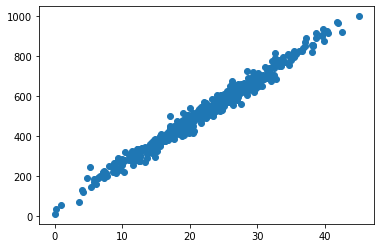

In [ ]:
plt.scatter(icecream_df['Temperature'], icecream_df['Revenue'])
plt.show()

In [ ]:
perceptron_regressor = tf.keras.models.Sequential()
perceptron_regressor.add(tf.keras.layers.Dense(units=1, input_shape=[1]))
perceptron_regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train = icecream_df['Temperature']
y_train = icecream_df['Revenue']

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                           patience=10)

perceptron_regressor.compile(optimizer=tf.optimizers.Adam(0.1), loss='mse')
epochs_info = perceptron_regressor.fit(X_train, y_train, epochs=1000,
                                       callbacks=[early_stopping_callback])

Epoch 1/1000
16/16 [==============================] - 1s 4ms/step - loss: 293559.3125
Epoch 2/1000
16/16 [==============================] - 0s 4ms/step - loss: 253369.8125
Epoch 3/1000
16/16 [==============================] - 0s 3ms/step - loss: 216820.0000
Epoch 4/1000
16/16 [==============================] - 0s 2ms/step - loss: 184370.5938
Epoch 5/1000
16/16 [==============================] - 0s 5ms/step - loss: 155623.9062
Epoch 6/1000
16/16 [==============================] - 0s 5ms/step - loss: 130511.5547
Epoch 7/1000
16/16 [==============================] - 0s 4ms/step - loss: 109070.3984
Epoch 8/1000
16/16 [==============================] - 0s 4ms/step - loss: 89969.9844
Epoch 9/1000
16/16 [==============================] - 0s 6ms/step - loss: 73940.0625
Epoch 10/1000
16/16 [==============================] - 0s 5ms/step - loss: 60249.1523
Epoch 11/1000
16/16 [==============================] - 0s 3ms/step - loss: 48942.1680
Epoch 12/1000
16/16 [==============================] - 0

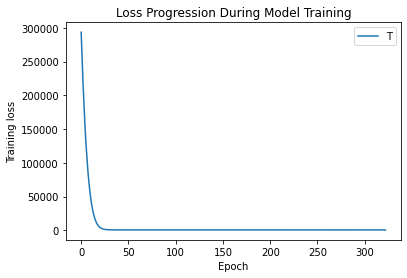

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.title("Loss Progression During Model Training")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.legend("Training loss")
plt.show()

Perceptron regressor weight:  [[21.614271]]
Perceptron regressor bias:  [40.0733]


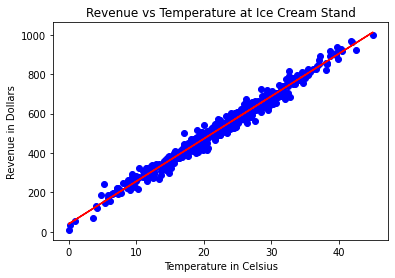

In [ ]:
print("Perceptron regressor weight: ", perceptron_regressor.get_weights()[0])
print("Perceptron regressor bias: ", perceptron_regressor.get_weights()[1])

plt.scatter(X_train, y_train, color='b')
plt.plot(X_train, perceptron_regressor.predict(X_train), color='r')
plt.title("Revenue vs Temperature at Ice Cream Stand")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

Linear regression coefficient:  [[21.44362551]]
Linear regression intercept:  [44.83126709]


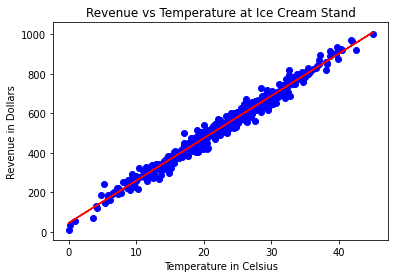

In [ ]:
X_train_reshaped = X_train.values.reshape(-1, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_reshaped, y_train_reshaped)

print("Linear regression coefficient: ", linear_regressor.coef_)
print("Linear regression intercept: ", linear_regressor.intercept_)

plt.scatter(X_train, y_train, color='b')
plt.plot(X_train_reshaped, linear_regressor.predict(X_train_reshaped),
         color='r')
plt.title("Revenue vs Temperature at Ice Cream Stand")
plt.xlabel("Temperature in Celsius")
plt.ylabel("Revenue in Dollars")
plt.show()

In [ ]:
temperature_test = 26

print("Perceptron regressor predicted revenue: ",
      np.round(perceptron_regressor.predict([temperature_test]), 2))
print("Linear regressor predicted revenue: ",
      np.round(linear_regressor.predict([[temperature_test]])))
print("Actual revenue: ", icecream_df.iloc[1, 1])

Perceptron regressor predicted revenue:  [[602.04]]
Linear regressor predicted revenue:  [[602.]]
Actual revenue:  625.1901215
